In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir']= os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import ParcelsRandom
from parcels import (FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode,
                     DiffusionUniformKh, AdvectionDiffusionM1, AdvectionDiffusionEM, Variable ,GeographicPolar,Geographic)
from parcels import plotTrajectoriesFile

import math

from datetime import timedelta
from operator import attrgetter

from copy import copy
from scipy import interpolate

from matplotlib import pyplot as plt, colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy

plt.ion()  # To trigger the interactive inline mode

In [2]:
### Global Constants
MIN_LON = -98.0
MAX_LON = -76.400024
MIN_LAT = 18.12
MAX_LAT = 31.92

#cell size
CELL_SIZE = 1/25

#earth radius in km 
EARTH_RADIUS_KM = 6371

## HYCOM + STOKES

In [3]:
# from distributed import LocalCluster, Client
# cluster = LocalCluster()
# client = Client(cluster)
# client

def download_netcdf_file(ds, file_name):
    try:
        os.remove(file_name)
        print("Done Deleting")
    except OSError:
        pass

    ds.to_netcdf(path = file_name)

In [12]:
# https://tds.hycom.org/thredds/dodsC/GOMu0.04/expt_90.1m000/data/hindcasts/2019
# https://tds.hycom.org/thredds/dodsC/GOMu0.04/expt_90.1m000/data/hindcasts/2020
# https://tds.hycom.org/thredds/dodsC/GOMu0.04/expt_90.1m000/data/hindcasts/2021
# https://tds.hycom.org/thredds/dodsC/GOMu0.04/expt_90.1m000/data/hindcasts/2022

# year = 2021
# hycom = xr.open_dataset('https://tds.hycom.org/thredds/dodsC/GOMu0.04/expt_90.1m000/data/hindcasts/' + year, decode_times=False, chunks='auto')
# hycom_dl = hycom_year.sel(depth = 0).isel(lon = slice(0,540)).drop(['depth','tau','water_temp','salinity', 'surf_el'])
# hycom_dl

In [4]:
hycom_2021 = xr.open_dataset('data/2020_GOM_HYCOM_raw.nc')
uv_hycom_2021 = hycom_2021.isel(time = 0)
landmask = np.ma.masked_invalid(uv_hycom_2021.water_u).mask & np.ma.masked_invalid(uv_hycom_2021.water_v).mask.astype('int')

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


#### CMEMS STOKES 

In [5]:
# THIS NEEDS TO BE RUN AND THEN WE HAVE ALL STOKES DATA
# stokes_2021 = xr.open_dataset('data\cmems_mod_glo_wav_my_0.2_PT3H-i_1684087883767.nc')
# stokes_2021 = stokes_2021.isel(latitude=slice(None, None, -1))
# stokes_2021
# download_netcdf_file(ds = stokes_2021, file_name = '2021_GOM_STOKES_raw.nc')

In [5]:
stokes_2021 = xr.open_dataset('data/2021_GOM_STOKES_raw.nc')
uv_stokes_2021 = stokes_2021.isel(time = 0)

## MASKS

#### Build GOM Masks

In [6]:
# https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_unstuck_Agrid.ipynb
###
def build_landmask(mask):
    """Function that builds a landmask from indicator data:
        - undefined = land
        - defined = ocean
    """
    landmask = np.ma.masked_invalid(mask)
    return landmask.mask.astype('int')


def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

def get_coastal_nodes_diagonal(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes where 
    one of the 8 nearest nodes is land. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')
    
    return coastal
    
def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where 
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask 
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

def create_displacement_field(landmask):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)
    shore_d = get_shore_nodes_diagonal(landmask) # bordering ocean directly and diagonally
    shore_c = shore_d - shore                    # corner nodes that only border ocean diagonally
    
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0) # Simple derivative
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Ly_c += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (-1,1), axis=(0,1)) # Include y-component of diagonal neighbours
    Ly_c += - np.roll(landmask, (1,-1), axis=(0,1)) - np.roll(landmask, (1,1), axis=(0,1))
    
    Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    Lx_c += np.roll(landmask, (-1,-1), axis=(1,0)) + np.roll(landmask, (-1,1), axis=(1,0)) # Include x-component of diagonal neighbours
    Lx_c += - np.roll(landmask, (1,-1), axis=(1,0)) - np.roll(landmask, (1,1), axis=(1,0))
    
    v_x = -Lx*(shore)
    v_y = -Ly*(shore)
    
    v_x_c = -Lx_c*(shore_c)
    v_y_c = -Ly_c*(shore_c)
    
    v_x = v_x + v_x_c
    v_y = v_y + v_y_c

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimension. This is a crude approximation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask) # direct neighbours
    dist = ci*dx                     # 1 dx away
    
    ci_d = get_coastal_nodes_diagonal(landmask) # diagonal neighbours
    dist_d = (ci_d - ci)*np.sqrt(2*dx**2)       # sqrt(2) dx away
        
    return dist+dist_d
###

In [7]:
def build_gom_masks(landmask):
    file_loc = '../gom_tests/depth_GOMu0.04_03i.nc'
    gom_depth = xr.open_dataset(file_loc).isel(MT=0, Longitude=slice(0, 540))
    
    #landmask = build_landmask(gom_depth.depth)
    
    # adjusted to remove border artifacts
    coastal = get_coastal_nodes_diagonal(landmask)
    coastal[:, -1] = 0.0
    coastal.T[:, 0] = 0.0
    
    shore = get_shore_nodes_diagonal(landmask)
    gom_depth = gom_depth.assign(landmask = (('Latitude', 'Longitude'), landmask))
    gom_depth = gom_depth.assign(coastalmask = (('Latitude', 'Longitude'), coastal))
    gom_depth = gom_depth.assign(shore = (('Latitude', 'Longitude'), shore))
    
    v_x, v_y = create_displacement_field(landmask)
    gom_depth = gom_depth.assign(disp_vx = (('Latitude', 'Longitude'), v_x))
    gom_depth = gom_depth.assign(disp_vy = (('Latitude', 'Longitude'), v_y))
    
    d_2_s = distance_to_shore(landmask)
    gom_depth = gom_depth.assign(d2s = (('Latitude', 'Longitude'), d_2_s))

    
    return gom_depth

In [8]:
gom_masks = build_gom_masks(landmask)
gom_masks

# Download GOM_Masks
# file_name = 'data/gom_masks.nc'
# download_netcdf_file(gom_masks, file_name)

<xarray.Dataset>
Dimensions:      (Latitude: 346, Longitude: 540)
Coordinates:
    MT           object 0001-01-16 00:00:00
    Date         float64 ...
  * Latitude     (Latitude) float32 18.12 18.16 18.2 18.24 ... 31.84 31.88 31.92
  * Longitude    (Longitude) float32 -98.0 -97.96 -97.92 ... -76.48 -76.44
Data variables:
    depth        (Latitude, Longitude) float32 ...
    landmask     (Latitude, Longitude) int32 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    coastalmask  (Latitude, Longitude) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 0
    shore        (Latitude, Longitude) int32 1 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    disp_vx      (Latitude, Longitude) float64 -0.7071 0.0 0.0 ... 0.0 0.0 0.0
    disp_vy      (Latitude, Longitude) float64 -0.7071 0.0 0.0 ... 0.0 0.0 0.0
    d2s          (Latitude, Longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    title:        HYCOM
    source:       HYCOM archive file
    experiment:   00.0
    history:      archv2ncdf2d

#### Display FieldSets

In [9]:
river_df = pd.read_csv('data/river_kg.csv')
sample_river_loc = river_df.sort_values(by='river_kg_mon', ascending=False).iloc[2]

c_lat = sample_river_loc.lats
c_lon = sample_river_loc.lons
shift = 2

ic_lat = np.where(gom_masks.Latitude == c_lat)[0][0]
ic_lon = np.where(gom_masks.Longitude == c_lon)[0][0]

#NEED TO CHECK IF WE ARE 'IN BOUNDS'
print(ic_lat, ic_lon)

latmin = ic_lat - 10
latmax = ic_lat + 10
lonmin = ic_lon - 10
lonmax = ic_lon + 10


print(lonmax -lonmin, latmax-latmin)
print(f"latmin: {latmin}, latmax: {latmax}, lonmin: {lonmin}, lonmax: {lonmax}" )

# lons_slice = slice(np.min(lons_plot), np.max(lons_plot))
# lats_slice = slice(np.min(lats_plot), np.max(lats_plot))
# print(f"lats_slice: {lats_slice}, lons_slice: {lons_slice}")

282 215
20 20
latmin: 272, latmax: 292, lonmin: 205, lonmax: 225


##### Landmask and Release Location

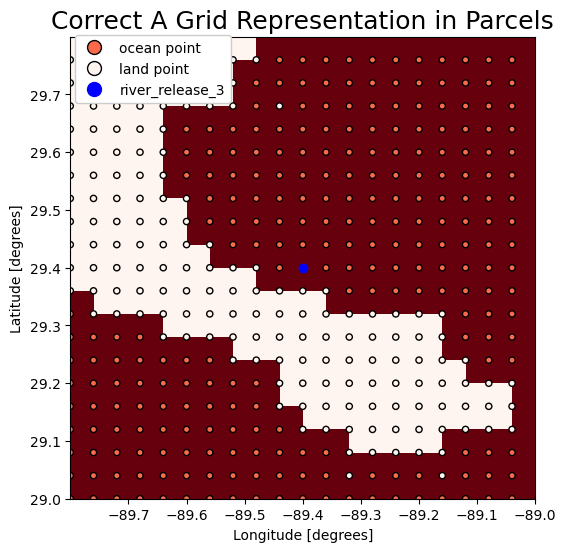

In [10]:
# https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_unstuck_Agrid.ipynb
# Velocity nodes
lon_vals, lat_vals = np.meshgrid(gom_masks['Longitude'], gom_masks['Latitude'])
lons_plot = lon_vals[latmin:latmax,lonmin:lonmax]
lats_plot = lat_vals[latmin:latmax,lonmin:lonmax]

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = gom_masks['Longitude'][:-1]+np.diff(gom_masks['Longitude'])/2
y = gom_masks['Latitude'][:-1]+np.diff(gom_masks['Latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

landmask = gom_masks.landmask
coastalmask = gom_masks.coastalmask
shoremask = gom_masks.shore
# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(gom_masks['Longitude'],gom_masks['Latitude'],landmask)

l_centers = fl(lon_centers[0,:],lat_centers[:,0])  

lmask = np.ma.masked_values(l_centers,1) # land when interpolated value == 1


custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = 'blue', marker='o', markersize=10, lw=0)]

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
ax1.set_title('Correct A Grid Representation in Parcels', fontsize=18)
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax1.scatter(c_lon, c_lat, c='blue')

ax1.legend(custom_lines, ['ocean point', 'land point', 'river_release_3'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

##### Coastal and Shore Masks

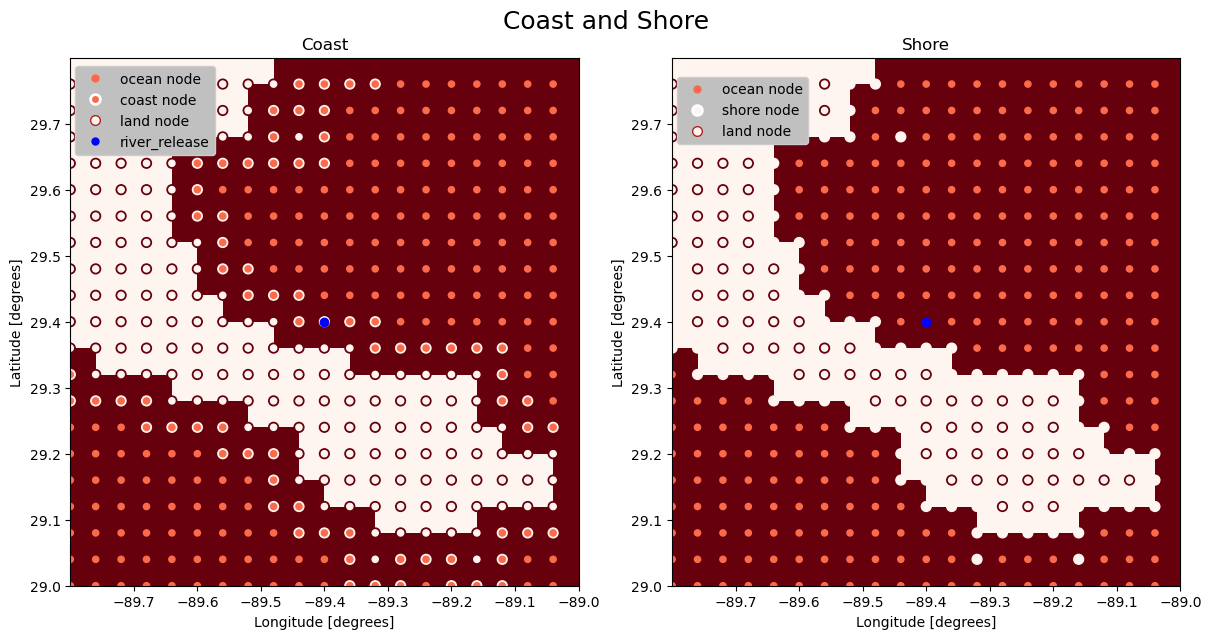

In [13]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
fig.suptitle('Coast and Shore', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land0 = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
coa = ax0.scatter(lons_plot,lats_plot, c=coastalmask[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)
ax0.scatter(c_lon, c_lat, c='blue')

ax0.set_title('Coast')
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0),
                Line2D([0], [0], c = 'blue', marker='o', markersize=5, lw=0)]
ax0.legend(custom_lines, ['ocean node', 'coast node', 'land node', 'river_release'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')


ax1 = fig.add_subplot(gs[0, 1])
land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
sho = ax1.scatter(lons_plot,lats_plot, c=shoremask[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)
ax1.scatter(c_lon, c_lat, c='blue')

ax1.set_title('Shore')
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0)]
ax1.legend(custom_lines, ['ocean node', 'shore node', 'land node'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')

#### Displacement Field

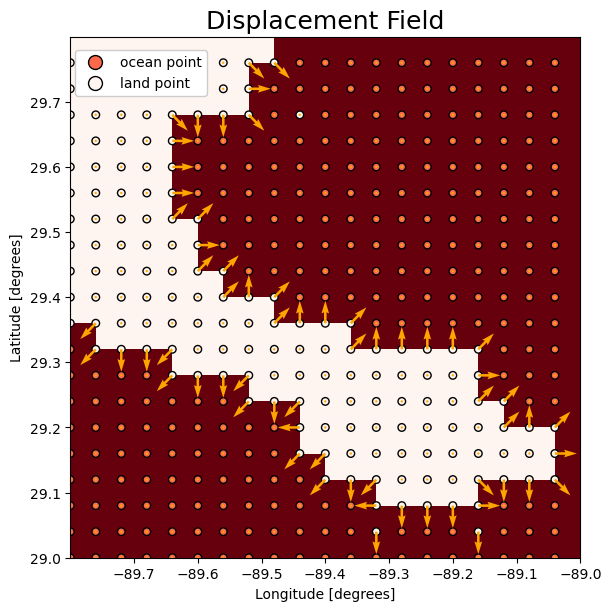

In [14]:
v_x, v_y = gom_masks.disp_vx, gom_masks.disp_vy
fig = plt.figure(figsize=(6,6), constrained_layout=True)
ax0 = fig.add_subplot()
ax0.set_title('Displacement Field', fontsize=18)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=30,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax0.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange',angles='xy', scale_units='xy', scale=29, width=0.005)

ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

#### Distance to Shore Mask

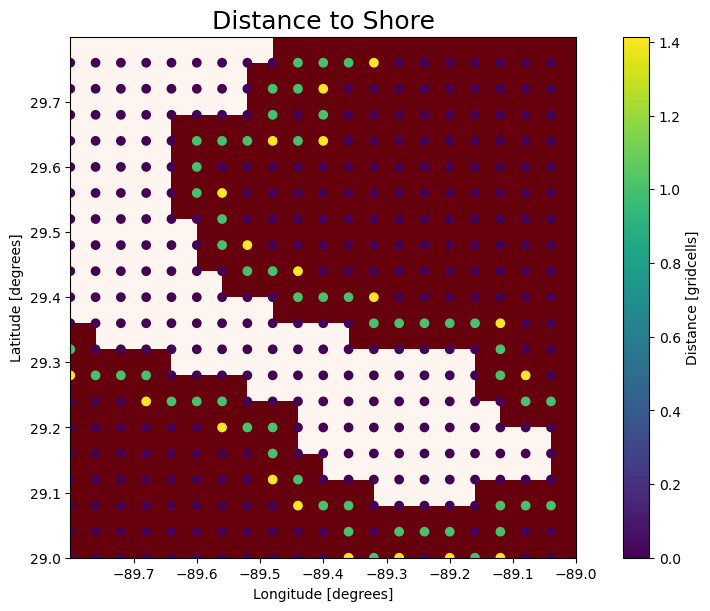

In [15]:
d_2_s = gom_masks.d2s
fig = plt.figure(figsize=(7,6), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Distance to Shore', fontsize=18)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
d2s = ax0.scatter(lons_plot,lats_plot, c = d_2_s[latmin:latmax,lonmin:lonmax])

plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]')

#### HYCOM UV Field Sample

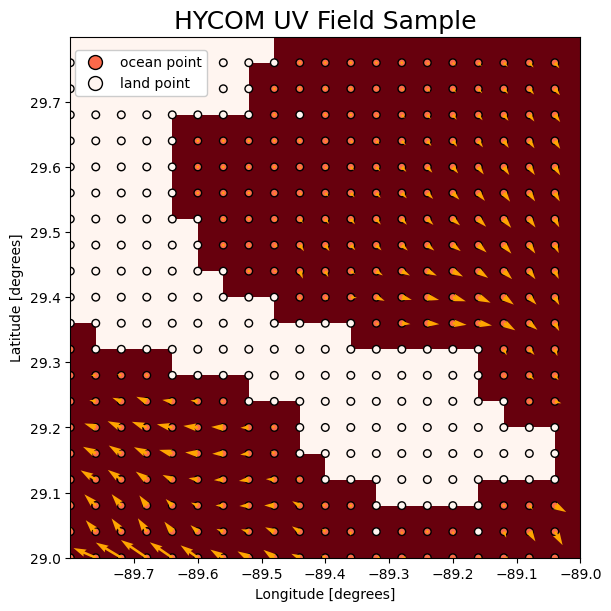

In [16]:
h_x, h_y = uv_hycom_2021.water_u.data, uv_hycom_2021.water_v.data
fig = plt.figure(figsize=(6,6), constrained_layout=True)
ax0 = fig.add_subplot()
ax0.set_title('HYCOM UV Field Sample', fontsize=18)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=30,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax0.quiver(lons_plot,lats_plot,h_x[latmin:latmax,lonmin:lonmax],h_y[latmin:latmax,lonmin:lonmax],color='orange',angles='xy', scale_units='xy', scale=7, width=0.005)

ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

#### All Vector Fields

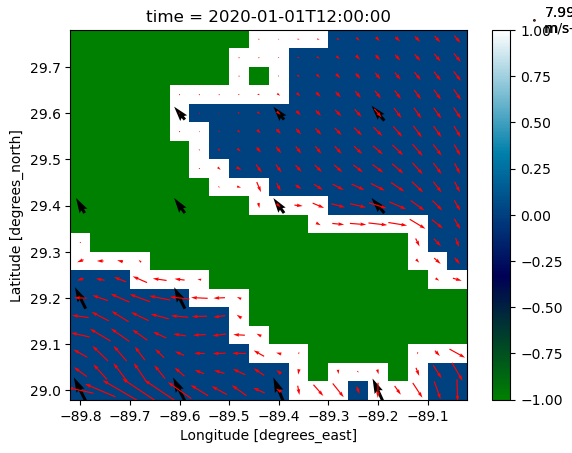

In [11]:
lons_slice = slice(np.min(lons_plot), np.max(lons_plot))
lats_slice = slice(np.min(lats_plot), np.max(lats_plot))

(gom_masks.coastalmask - gom_masks.landmask).sel(Latitude = lats_slice, Longitude = lons_slice).plot(cmap="ocean")
uv_stokes_2021.sel(latitude = lats_slice, longitude = lons_slice).plot.quiver(x="longitude", y="latitude", u="VSDX", v="VSDY")
uv_hycom_2021.sel(lat = lats_slice, lon = lons_slice).plot.quiver(x="lon", y="lat", u="water_u", v="water_v", color="Red")

#### Testing Release Domain

slice(-90.19998779296876, -88.63997802734374, None) slice(28.6, 30.160000228881835, None)


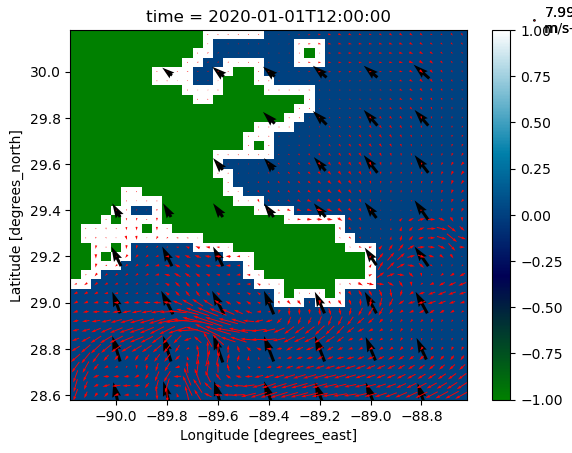

In [21]:
steps = CELL_SIZE * 10
lons_slice = slice(np.min(lons_plot) - steps, np.max(lons_plot) + steps)
lats_slice = slice(np.min(lats_plot) - steps, np.max(lats_plot) + steps)

print(lons_slice, lats_slice)
(gom_masks.coastalmask - gom_masks.landmask).sel(Latitude = lats_slice, Longitude = lons_slice).plot(cmap="ocean")
uv_stokes_2021.sel(latitude = lats_slice, longitude = lons_slice).plot.quiver(x="longitude", y="latitude", u="VSDX", v="VSDY")
uv_hycom_2021.sel(lat = lats_slice, lon = lons_slice).plot.quiver(x="lon", y="lat", u="water_u", v="water_v", color="Red")